In [1]:
import itertools
import os
import pandas as pd
from deepface import DeepFace
from deepface.commons import distance
from tqdm import tqdm

In [2]:
idendities = {
 "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg", "img5.jpg", "img6.jpg", "img7.jpg", "img10.jpg", "img11.jpg"],
 "Scarlett": ["img8.jpg", "img9.jpg"],
 "Jennifer": ["img3.jpg", "img12.jpg"],
 "Mark": ["img13.jpg", "img14.jpg", "img15.jpg"],
 "Jack": ["img16.jpg", "img17.jpg"],
 "Elon": ["img18.jpg", "img19.jpg"],
 "Jeff": ["img20.jpg", "img21.jpg"],
 "Marissa": ["img22.jpg", "img23.jpg"],
 "Sundar": ["img24.jpg", "img25.jpg"]
}

In [3]:
positives = []
for key, values in idendities.items():
 for i in range(0, len(values)-1):
  for j in range(i+1, len(values)):
   positive = []
   positive.append(values[i])
   positive.append(values[j])
   positives.append(positive)
 
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [4]:
samples_list = list(idendities.values())
 
negatives = []
for i in range(0, len(idendities) - 1):
 for j in range(i+1, len(idendities)):
  cross_product = itertools.product(samples_list[i], samples_list[j])
  cross_product = list(cross_product)
 
  for cross_sample in cross_product:
   negative = []
   negative.append(cross_sample[0])
   negative.append(cross_sample[1])
   negatives.append(negative)
 
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [5]:
df = pd.concat([positives, negatives]).reset_index(drop = True)
 
df.file_x = "dataset/"+df.file_x
df.file_y = "dataset/"+df.file_y

In [8]:
distance_metrics = ["cosine", "euclidean", "euclidean_l2"]

if not os.path.exists("results.csv"):
    model_name = "VGG-Face"
    for index, instance in tqdm(df.iterrows(), total = df.shape[0]):
            first_embedding = DeepFace.represent(instance["file_x"], model_name = model_name)[0]["embedding"]
            second_embedding = DeepFace.represent(instance["file_y"], model_name = model_name)[0]["embedding"]

            for distance_metric in distance_metrics:
                if distance_metric == "cosine":
                    dst = distance.findCosineDistance(first_embedding, second_embedding)
                elif distance_metric == "euclidean":
                    dst = distance.findEuclideanDistance(first_embedding, second_embedding)
                elif distance_metric == "euclidean_l2":
                    dst = distance.findEuclideanDistance(distance.l2_normalize(first_embedding), distance.l2_normalize(second_embedding))

                df.loc[index, distance_metric] = dst
                
    df.to_csv("results.csv")
else:
    df = pd.read_csv("results.csv")

100%|██████████| 300/300 [03:26<00:00,  1.45it/s]


In [9]:
df.head()

,Unnamed: 0,file_x,file_y,decision,cosine,euclidean,euclidean_l2
0,0,dataset/img1.jpg,dataset/img2.jpg,Yes,0.432321,0.929862,0.929862
1,1,dataset/img1.jpg,dataset/img4.jpg,Yes,0.425784,0.922805,0.922805
2,2,dataset/img1.jpg,dataset/img5.jpg,Yes,0.558475,1.056858,1.056858
3,3,dataset/img1.jpg,dataset/img6.jpg,Yes,0.518531,1.018362,1.018363
4,4,dataset/img1.jpg,dataset/img7.jpg,Yes,0.529055,1.028645,1.028645


<AxesSubplot:ylabel='Density'>

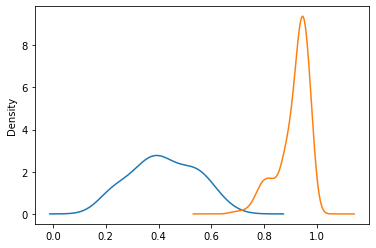

In [10]:
df[df["decision"] == "Yes"]["cosine"].plot.kde()
df[df["decision"] == "No"]["cosine"].plot.kde()

<AxesSubplot:ylabel='Density'>

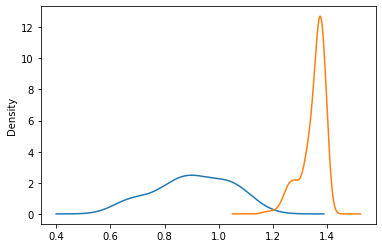

In [11]:
df[df["decision"] == "Yes"]["euclidean"].plot.kde()
df[df["decision"] == "No"]["euclidean"].plot.kde()

<AxesSubplot:ylabel='Density'>

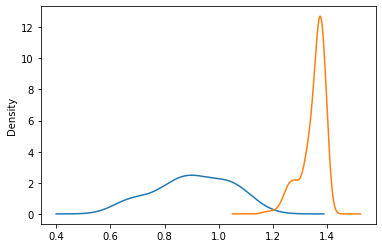

In [12]:
df[df["decision"] == "Yes"]["euclidean_l2"].plot.kde()
df[df["decision"] == "No"]["euclidean_l2"].plot.kde()

In [ ]:
from chefboost import Chefboost as chef
config = {'algorithm': 'C4.5'}
tmp_df = df[['euclidean_l2', 'decision']].rename(columns = {"decision": "Decision"}).copy()
model = chef.fit(tmp_df, config)